В предыдущей главе камера была задана только своей системой координат. Она могла перемещаться по сцене, но не умела создавать изображений. В этой главе мы исправим этот недостаток, добавив к системе координат модель камеры. Это позволит описать математическим языком преобразование трехмерной сцены в двухмерное изображение. 

# Модель камеры

## Точечная камера

Простая модель камеры не учитывает искажений, связанных с физическими явлениями, и имеет следующий вид

$s \; p = K \; [R \; | \; t] \; P_W$, где <br />

$P_W$ - координаты точки в мировой с.к., p &ndash; пиксельные координаты на плоскости изображения, K &ndash; матрица внутренних параметров камеры, R, t &ndash; поворот и перенос, необходимые для перехода от мировых координат к координатам камеры, s &ndash; фактор масштаба, зависящий от конкретной точки и не входящий в состав модели камеры.

Можно говорить, что преобразование, выполняемое камерой, является композицией 2х компонент (матриц). Первая компонента &ndash; $[R | t]$ матрица внешних (extrinsic) параметров. Она описывает переход от мировых координат к координатам камеры $P_C = [R \;| \;t] \; P_W $. Вторая компонента   &ndash;  матрица внутренних (intrinsic) параметров $K$, определяет расположение и структуру плоскости, на которой будет построено изображение. Матрица K действует на точки в с.к. камеры ($s \; p = K \; P_C$).


Из двумерных координат нас будут интересовать нормализованные и пиксельные. Нормализованные координаты получаются с помощью перспективного преобразования, для это достаточно разделить координатный вектор на z-координату, тогда все точки окажутся на плоскости z = 1 в системе координат, связанной с камерой: 

$Z_c \begin{bmatrix} 
    x' \\
    y' \\
    1
\end{bmatrix} 
= \begin{bmatrix} 
    X_C \\
    Y_C \\
    Z_C
\end{bmatrix}
= [R | t] \begin{bmatrix} 
    X_W \\
    Y_W \\
    Z_W \\
    1
\end{bmatrix}$

Спроецированные точки могут иметь как положительные, так и отрицательные координаты, центр изображения будет располагаться в точке $(x', y') = (0, 0)$. Но если открыть изображение в каком-нибудь графическом редакторе, то начало координат окажется в верхнем левом углу, а положительные оси будут направлены вниз и вправо. Это базис, связанный с пиксельными координатами. Переход к пиксельным координатам выполняет вот так

$\begin{bmatrix} 
        u \\ 
        v
\end{bmatrix} = 
\begin{bmatrix}
        f \; x' + c_x \\
        f \; y' + c_y
\end{bmatrix} = 
\begin{bmatrix}
        f \; X_C / Z_C + c_x \\
        f \; Y_C / Z_C + c_y
\end{bmatrix}$

вектор $(c_x, c_y)$ смещает центр в нужную точку, а множитель $f$ позволяют учесть сдвиг плоскости изображения на фокусное расстояние камеры. Впрочем, на практике все ещё хитрее, и множитель $f$ тоже превращают в вектор, который позволяет учесть различия между $x$- и $y$-осями матрицы камеры: 

$\begin{bmatrix} 
        u \\ 
        v
\end{bmatrix} = 
\begin{bmatrix}
        f_x \; x' + c_x \\
        f_y \; y' + c_y
\end{bmatrix} = 
\begin{bmatrix}
        f_x \; X_C / Z_C + c_x \\
        f_y \; Y_C / Z_C + c_y
\end{bmatrix}$

Описанный набор параметров можно представить в виде матрицы

$K = \begin{bmatrix} 
        f_x & 0    & c_x \\ 
        0   & f_y  & c_y \\
        0   & 0    & 1
\end{bmatrix}$

которая при умножении даст искомые пиксельные координаты 

$K \begin{bmatrix} 
        x' \\ 
        y' \\
        1
\end{bmatrix} = 
\begin{bmatrix}
        f_x \; x' + c_x \\
        f_y \; y' + c_y \\
        1
\end{bmatrix} =
\begin{bmatrix} 
        u \\ 
        v \\
        1
\end{bmatrix}$




Таким образом, зная расположение объектов в мировой с.к., положение камеры и её внутренние параметры, мы можем выполнить преобразования:  мир -> камера -> нормализованные экранные координаты -> пиксельные координаты. А затем определить для каждой видимой точки её место на изображении.

Подробности см. https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b 



<img src="../assets/images/pinhole_camera_model_opencv.png" alt="pinhole camera" style="background-color:#d3d3d3"/> 
</br>
*Рисунок с сайта OpenCV

Модели камер в библиотеке pytorch3d

https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/renderer/cameras.py

### Задачи на применение перспективной модели камеры

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os 
import sys

# add parent dir to import path 
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import utils.frame_plotter as fp
import utils.scene_elements as se
import utils.models as models

Если удалось разобраться в теме преобразования координат, то задачи этого раздела не будут представлять существенной сложности. Просто добавляем ещё одно преобразование, необходимое, чтобы перевести трехмерную сцену в плоское двумерное изображение. В качестве сцены будет выступать вот такой домик:

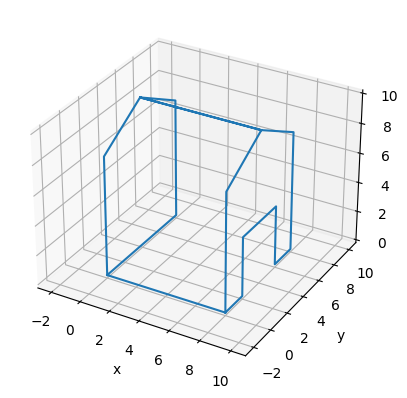

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = models.house.T
ax.plot(x, y, z)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Сперва настроим ориентацию камеры. В зависимости от области применения существуют разные взгляды на то, как это следует делать. Но сейчас речь идет о компьютерном зрении, поэтому мы возьмем ориентацию, которая используется в библиотеке OpenCV: положительное направление оси Z направлено в сторону сцены, ось X идет направо, ось Y &ndash; вниз. Подробнее см. на рисунке в теоретической части.

#### Задание 1

Задать матрицу преобразования камеры, расположенной в точке $O_W = (14,2,2)$. Базис камеры сориентирован как на рис. ниже: $Z_C = -X_w$, $Y_C = -Z_W$, $X_C = Y_W$. Найти матрицу преобразования. 

Подсказка: формулировка задачи не указывает явным образом, вокруг каких осей нужно совершать повороты. Но тем не менее, можно представить себе, какие 2 поворота нужно выполнить относительно мирового базиса, чтобы получить ориентацию базиса камеры.

In [ ]:
WO_c = np.array([14,2,2])

T = None

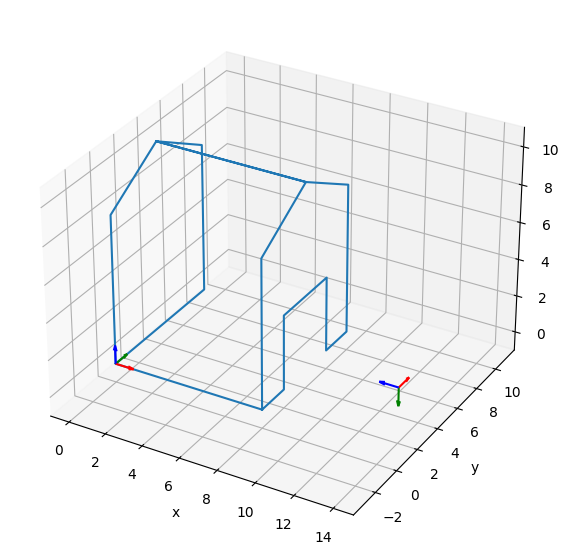

In [14]:
# визуализация расположения камеры

Ry = np.array([[0, 0,-1],
               [0, 1, 0],
               [1, 0, 0]])
Rx = np.array([[1, 0, 0],
               [0, 0, 1],
               [0,-1, 0]])

world_basis = se.Basis()
cam_basis = se.Basis(origin=np.array([14,2,2]),
                     basis=Rx @ Ry)
camera = se.Camera(basis=cam_basis)

x, y, z = models.house.T

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
world_basis.draw(ax)
camera.draw(ax)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
# решение

#### Задание 2 

Пусть камера, описанная в задании 1, имеет единичную матрицу внутренних параметров $K = I$. Нужно спроецировать координаты точек домика на плоскость изображения камеры.

In [ ]:
K = np.eye(3)
points_3d = models.house

In [ ]:
# решение
K = np.eye(3)
points_3d = models.house

Rt = None
P = K @ Rt
hom_points = np.vstack((points_3d.T, np.ones(points_3d.shape[0])))
camera_points = P @ hom_points
proj_points = camera_points / camera_points[2]

Загадка на внимательность: если построить получившиеся точки с помощью библиотеки matplotplib, то изображение окажется перевернутым. На самом деле это правильное поведение, но почему? Как это можно исправить?

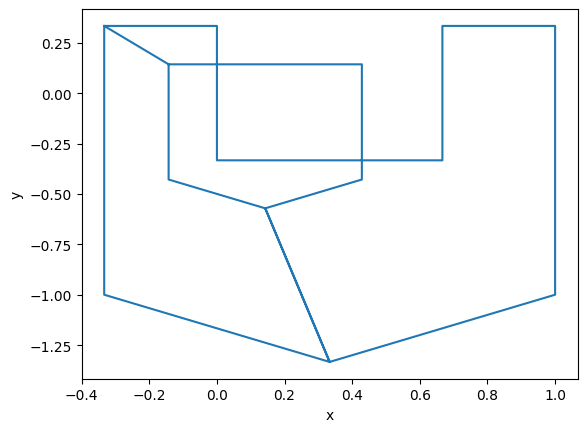

In [3]:
Ry = np.array([[0, 0,-1],
               [0, 1, 0],
               [1, 0, 0]])
Rx = np.array([[1, 0, 0],
               [0, 0, 1],
               [0,-1, 0]])

cam_basis = se.Basis(origin=np.array([14,2,2]),
                     basis=Rx @ Ry)
camera = se.Camera(basis=cam_basis)
proj_points = camera.project(models.house)

x, y = proj_points.T
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

Ответ: в системе координат камеры ось Y направлена вниз, а на двумерных изображениях, которые создает matplotlib, она по-умолчанию направлена вверх. Поэтому, чтобы получить правильное изображение, нужно настроить оси.

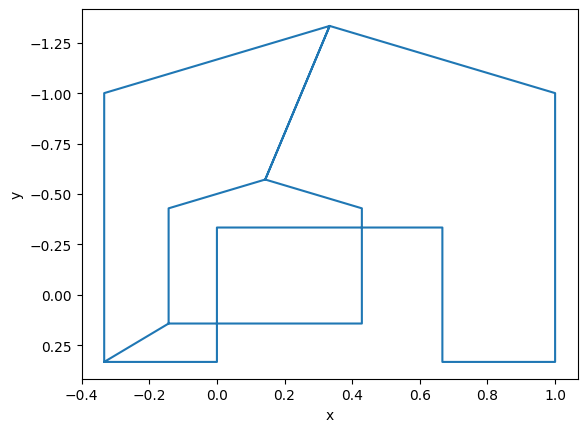

In [11]:
Ry = np.array([[0, 0,-1],
               [0, 1, 0],
               [1, 0, 0]])
Rx = np.array([[1, 0, 0],
               [0, 0, 1],
               [0,-1, 0]])

cam_basis = se.Basis(origin=np.array([14,2,2]),
                     basis=Rx @ Ry)
camera = se.Camera(basis=cam_basis)
points = camera.project(models.house)

x, y = points.T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.gca().invert_yaxis() # опция настройки оси y
plt.show()

### Задание 3 

Матрица внутренних параметров больше не единичная. Проверим, как будет изменяться изображение, получаемое камерой. 

Задание полезно попробовать решить методом пристального взгляда. 

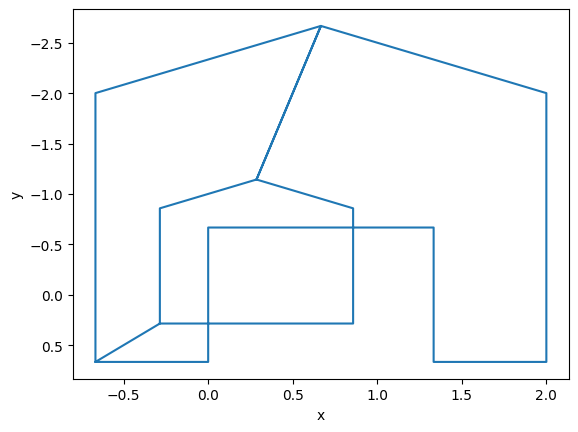

In [12]:
# матрица внутренних параметров имеет вид
K = np.array([[2, 0, 0],
              [0, 2, 0],
              [0, 0, 1]])
# как изменится изображение в плоскости камеры?


Ry = np.array([[0, 0,-1],
               [0, 1, 0],
               [1, 0, 0]])
Rx = np.array([[1, 0, 0],
               [0, 0, 1],
               [0,-1, 0]])

cam_basis = se.Basis(origin=np.array([14,2,2]),
                     basis=Rx @ Ry)
camera = se.Camera(basis=cam_basis, K = K)
points = camera.project(models.house)

x, y = points.T
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.gca().invert_yaxis() 
plt.show()

Ответ: произошло изменение масштаба изображения согласно формуле 

$\begin{bmatrix} 
        u \\ 
        v
\end{bmatrix} = 
\begin{bmatrix}
        f \; x' + c_x \\
        f \; y' + c_y
\end{bmatrix} = 
\begin{bmatrix}
        2 \; X_C / Z_C + 0 \\
        2 \; Y_C / Z_C + 0
\end{bmatrix}$

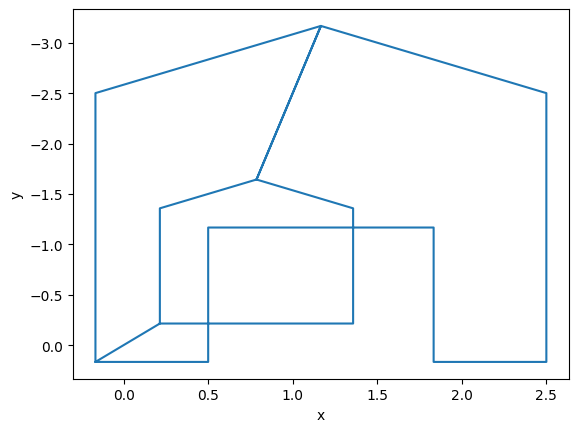

In [15]:
# матрица внутренних параметров имеет вид
K = np.array([[2, 0, 0.5],
              [0, 2,-0.5],
              [0, 0, 1]])
# как изменится изображение в плоскости камеры?

Ry = np.array([[0, 0,-1],
               [0, 1, 0],
               [1, 0, 0]])
Rx = np.array([[1, 0, 0],
               [0, 0, 1],
               [0,-1, 0]])

cam_basis = se.Basis(origin=np.array([14,2,2]),
                     basis=Rx @ Ry)
camera = se.Camera(basis=cam_basis, K = K)
points = camera.project(models.house)

x, y = points.T
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.gca().invert_yaxis() 
plt.show()

# Картинка на первый взгляд не изменилась, но как насчет масштаба осей?

Ответ: произошло изменение масштаба изображения и сдвиг

$\begin{bmatrix} 
        u \\ 
        v
\end{bmatrix} = 
\begin{bmatrix}
        f \; x' + c_x \\
        f \; y' + c_y
\end{bmatrix} = 
\begin{bmatrix}
        2 \; X_C / Z_C + 0.5 \\
        2 \; Y_C / Z_C - 0.5
\end{bmatrix}$